In [1]:
import pandas as pd
import numpy as np
import matplotlib.dates as md
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
#from pyemma import msm
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
#reading the dataset and converting date & time column into datetime obj
#this is the second station which has more data
f=pd.read_csv('HogIsland.csv')

keep_col = ['agency_cd','site_no','datetime','tz_cd','106605_00095','106608_00300','106611_62361','106617_63680']
new_f = f[keep_col]
#new_f['datetime'] =  pd.to_datetime(new_f['datetime'])
new_f = new_f[['agency_cd','site_no','datetime','106605_00095','106608_00300','106611_62361','106617_63680']]
new_f = new_f.rename(columns={'106605_00095': 'SC', '106608_00300': 'DO', '106611_62361': 'CL', '106617_63680': 'TR'})
new_f.head(2)

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,agency_cd,site_no,datetime,SC,DO,CL,TR
0,USGS,1311143,21/10/2010 00:00,44900.0,6.8,3.2,NaN
1,USGS,1311143,21/10/2010 00:06,44800.0,6.9,3.5,NaN


In [3]:
new_f['datetime'] =  pd.to_datetime(new_f['datetime'], format='%d/%m/%Y %H:%M')

In [4]:
# copy dataframe
df = new_f.copy()
# var = ['Specific Conductance','Dissolved Oxygen','Chlorophyll']
# window_SC = 9600
# window_DO = 9600
# min_val = 1
# for i in range(len(var)):
#     df[var[i]].fillna(df[var[i]].rolling(window, center=True, min_periods = min_val).mean(), inplace=True)

In [5]:
df = df[:219990]

In [6]:
def fill_nan(df, var1, var2, window, min_val):
    df[var2] = df[var1]
    df[var2].fillna(df[var2].rolling(window, center=True, min_periods = min_val).mean(), inplace=True)
    print(df[var1].isnull().sum().sum(),df[var2].isnull().sum().sum())

In [7]:
def rec_fill_nan(df, var1, var2, window, min_val):
    df[var2] = df[var1]
    while df[var2].isnull().sum().sum() != 0:
        #print(df[var2].isnull().sum().sum())
        df[var2].fillna(df[var2].rolling(window, center=True, min_periods = min_val).mean(), inplace=True)

In [8]:
def plot_gaps(df, var1, var2):
#     plt.figure(figsize=(16,3))
#     df[var2].plot(color='r', label='gap')
#     df[var1].plot(color='b', label='regular')
    df.plot(x='datetime', y=[var2,var1], color=['r','b'], label=['gap','regular'],figsize=(16,3))
    plt.legend(loc='upper left')
    plt.xlabel('Date time')
    plt.ylabel(var1)
    plt.show()

/usr/local/lib/python3.5/dist-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


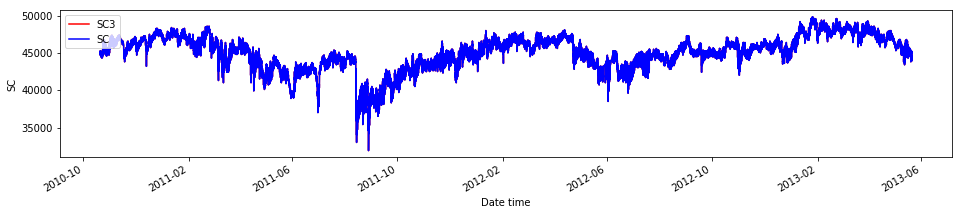

In [13]:
# fill Specific conductance recursively using 3 days data (current, before and after day)
rec_fill_nan(df, 'SC', 'SC3', 720, 1)
plot_gaps(df, 'SC', 'SC3')

/usr/local/lib/python3.5/dist-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


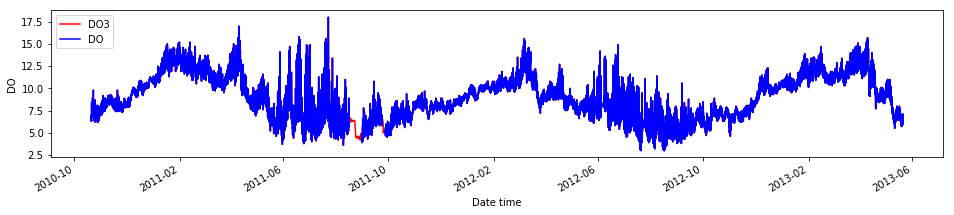

In [14]:
# fill Specific conductance recursively using 3 days data (current, before and after day)
rec_fill_nan(df, 'DO', 'DO3', 720, 1)
plot_gaps(df, 'DO', 'DO3')

/usr/local/lib/python3.5/dist-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


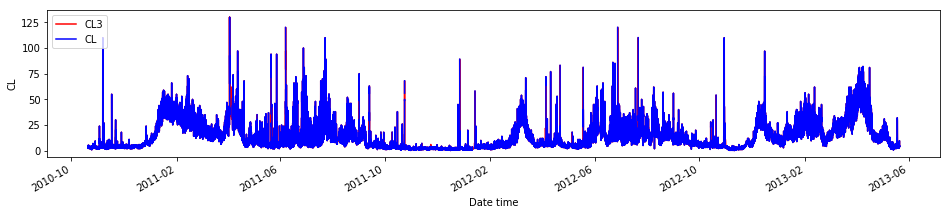

In [15]:
# fill Specific Chl recursively using 3 days data (current, before and after day)
rec_fill_nan(df, 'CL', 'CL3', 720, 1)
plot_gaps(df, 'CL', 'CL3')

# Shared Variables

In [16]:
data = df[['CL3','SC3', 'DO3']]
outliers_fraction = 0.01

# Clustering Anomaly Detection

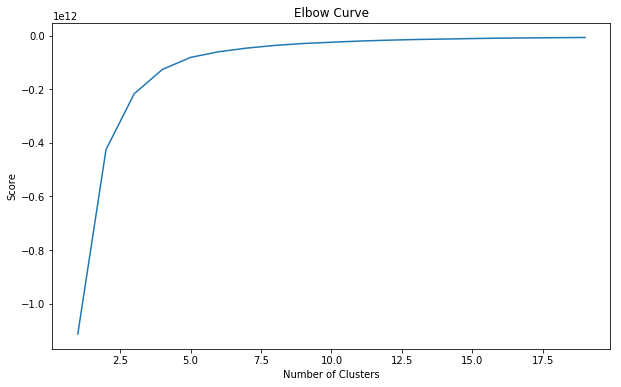

In [17]:
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(n_cluster, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

Text(0.5,0.92,'K Means')

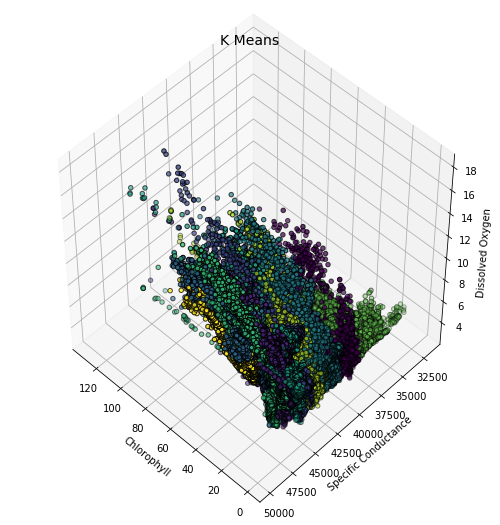

In [21]:
X = df[['CL3','SC3', 'DO3']]
X = X.reset_index(drop=True)
km = KMeans(n_clusters=10)
km.fit(X)
km.predict(X)
labels = km.labels_
#Plotting
fig = plt.figure(1, figsize=(7,7))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
ax.scatter(X.iloc[:,0], X.iloc[:,1], X.iloc[:,2],c=labels.astype(np.float), edgecolor="k")
ax.set_xlabel('Chlorophyll')
ax.set_ylabel('Specific Conductance')
ax.set_zlabel('Dissolved Oxygen')
plt.title('K Means', fontsize=14)

In [36]:
X.head()

,CL3,SC3,DO3
0,3.2,44900.0,6.8
1,3.5,44800.0,6.9
2,4.0,44800.0,6.9
3,3.8,44800.0,6.9
4,3.3,44800.0,7.0


In [63]:
scaler = StandardScaler()
transformed = scaler.fit_transform(X)
# fitted = scaler.fit(X)
# transformed = scaler.transform(X)
transformed = pd.DataFrame(transformed)
transformed.head()

,0,1,2
0,-0.831551,-0.052156,-0.827589
1,-0.807086,-0.096605,-0.785555
2,-0.766309,-0.096605,-0.785555
3,-0.782620,-0.096605,-0.785555
4,-0.823396,-0.096605,-0.743521


In [65]:
inverse_transformed = scaler.inverse_transform(transformed)
inverse_transformed = pd.DataFrame(inverse_transformed)
inverse_transformed.head()

,0,1,2
0,3.2,44900.0,6.8
1,3.5,44800.0,6.9
2,4.0,44800.0,6.9
3,3.8,44800.0,6.9
4,3.3,44800.0,7.0


In [66]:
data = df[['CL3', 'SC3', 'DO3']]

In [69]:
transformed.head()

,0,1,2
0,-0.831551,-0.052156,-0.827589
1,-0.807086,-0.096605,-0.785555
2,-0.766309,-0.096605,-0.785555
3,-0.782620,-0.096605,-0.785555
4,-0.823396,-0.096605,-0.743521


In [224]:
# transformed

In [68]:
pca = PCA(n_components=2)
data_pca = pca.fit_transform(transformed)
data_pca = pd.DataFrame(data_pca)
data_pca.head()

,0,1
0,-1.011078,-0.555557
1,-0.994298,-0.507609
2,-0.972947,-0.478155
3,-0.981488,-0.489936
4,-0.975021,-0.519850


In [ ]:
kmeans = [KMeans(n_clusters=i).fit(data_pca) for i in n_cluster]
df['cluster'] = kmeans[9].predict(data_pca)

In [78]:
df.index = data_pca.index
df['principal_feature1'] = data_pca[0]
df['principal_feature2'] = data_pca[1]
df['cluster'].value_counts()

1    50585
2    38453
6    32260
9    20769
7    19818
0    18003
5    15938
4    10575
8     6883
3     6706
Name: cluster, dtype: int64

In [79]:
# return Series of distance between each point and its distance with the closest centroid
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.set_value(i, np.linalg.norm(Xa-Xb))
    return distance

In [80]:
outliers_fraction = 0.01
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(data_pca, kmeans[9])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly1 contain the anomaly result of the above method Cluster (0:normal, 1:anomaly) 
df['anomaly1'] = (distance >= threshold).astype(int)

/usr/lib/python3/dist-packages/ipykernel/__main__.py:7: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


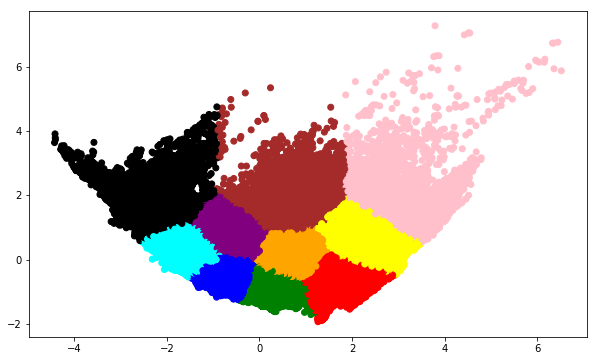

In [81]:
#plot the different clusters with the 2 main features
fig, ax = plt.subplots(figsize=(10,6))
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'lightblue'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["cluster"].apply(lambda x: colors[x]))
plt.show()

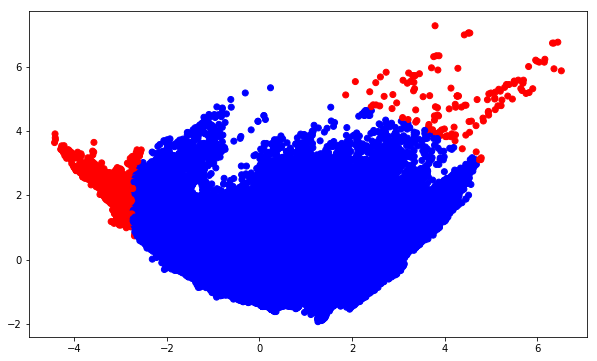

In [82]:
fig, ax = plt.subplots(figsize=(10,6))
colors = {0:'blue', 1:'red'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly1"].apply(lambda x: colors[x]))
plt.show()

In [88]:
def plot_outlier(df, ano_col, var):
    fig, ax = plt.subplots(figsize=(16,3))
    a = df.loc[df[ano_col] == 1, ['date_time_int', var]]
    ax.plot(df['date_time_int'], df[var], color='b', label = 'Normal')
    ax.scatter(a['date_time_int'],a[var], color='r', label = 'Anomaly')
    plt.title(var)
    plt.legend()
    plt.show()

In [91]:
# convert datetime to integer
df = df.sort_values('datetime')
df['date_time_int'] = df.datetime.astype(np.int64)

In [92]:
data.columns

Index(['CL3', 'SC3', 'DO3'], dtype='object')

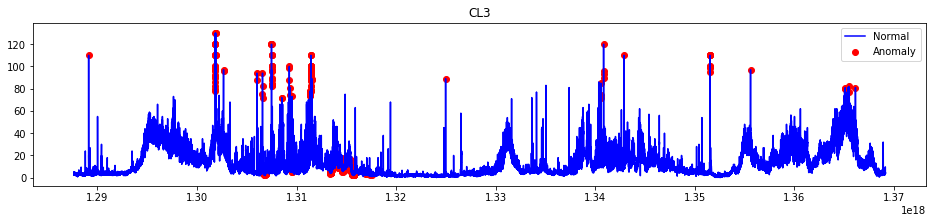

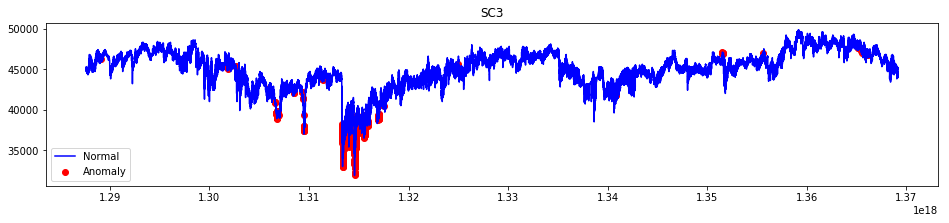

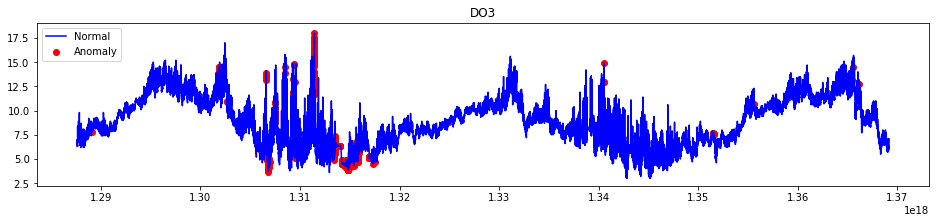

In [108]:
# data = df[['CL3','SC3', 'DO3']]
# outliers_fraction = 0.01

for key in data.columns:
    plot_outlier(df, 'anomaly1', key)

# Isolation Forest

In [109]:
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data_pca)
df['anomaly2'] = pd.Series(model.predict(data_pca))
df['anomaly2'] = df['anomaly2'].map({1:0, -1:1})

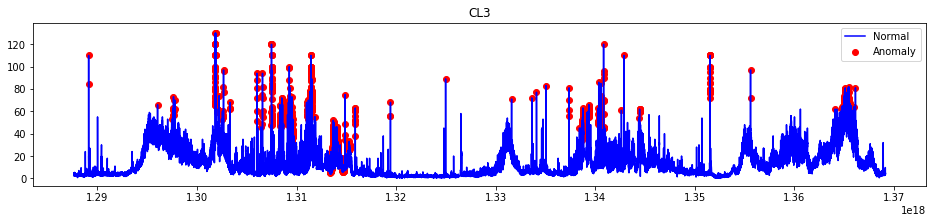

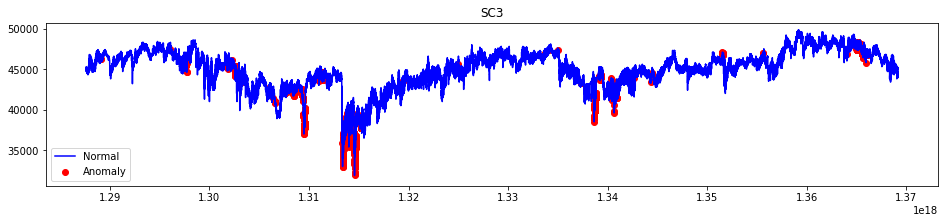

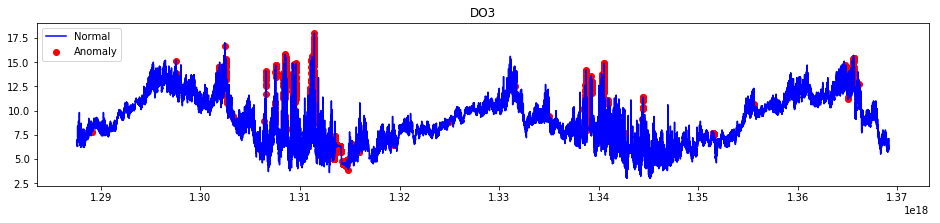

In [116]:
for key in data.columns:
    plot_outlier(df, 'anomaly2', key)

# One class SVM

In [118]:
model = OneClassSVM(nu=outliers_fraction, kernel='rbf', gamma=0.01)
model.fit(data_pca)
df['anomaly3'] = pd.Series(model.predict(data_pca))
df['anomaly3'] = df['anomaly3'].map({1:0, -1:1})

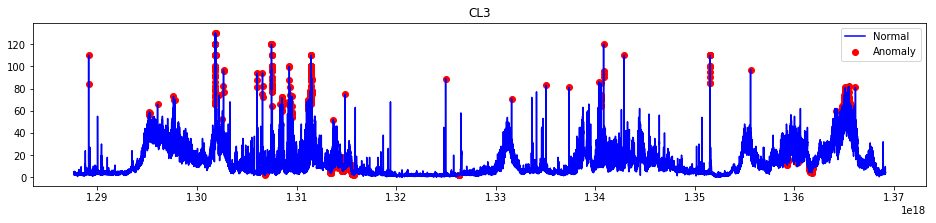

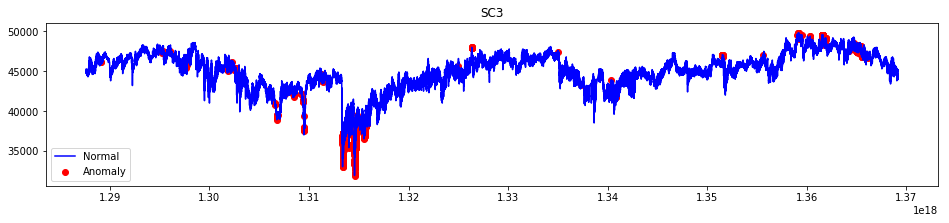

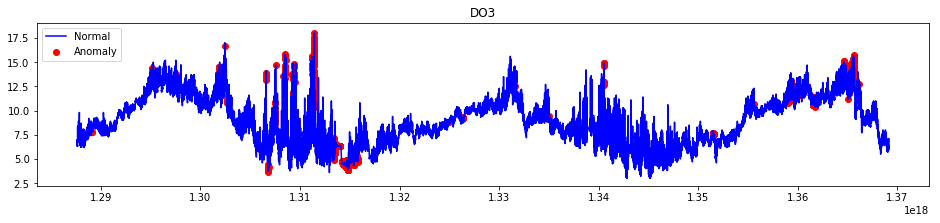

In [119]:
# data = df[['CL3','SC3', 'DO3']]
# outliers_fraction = 0.01

for key in data.columns:
    plot_outlier(df, 'anomaly3', key)

# Anomaly Detection using Gaussian Distribution

In [120]:
from sklearn.covariance import EllipticEnvelope
clf = EllipticEnvelope(contamination=0.01,random_state=0)
clf.fit(data_pca)
ee_scores = pd.Series(clf.decision_function(data_pca)) 
ee_predict = clf.predict(data_pca)

In [121]:
df['anomaly4'] = ee_predict

In [122]:
df['anomaly4'] = df['anomaly4'].map({1:0, -1:1})

In [123]:
df.head(2)

,agency_cd,site_no,datetime,SC,DO,CL,TR,SC3,DO3,CL3,cluster,principal_feature1,principal_feature2,anomaly1,date_time_int,anomaly2,anomaly3,anomaly4
0,USGS,1311143,2010-10-21 00:00:00,44900.0,6.8,3.2,NaN,44900.0,6.8,3.2,1,-1.011078,-0.555557,0,1287619200000000000,0,0,0
1,USGS,1311143,2010-10-21 00:06:00,44800.0,6.9,3.5,NaN,44800.0,6.9,3.5,1,-0.994298,-0.507609,0,1287619560000000000,0,0,0


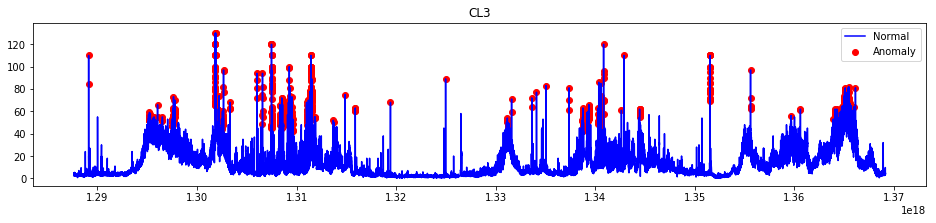

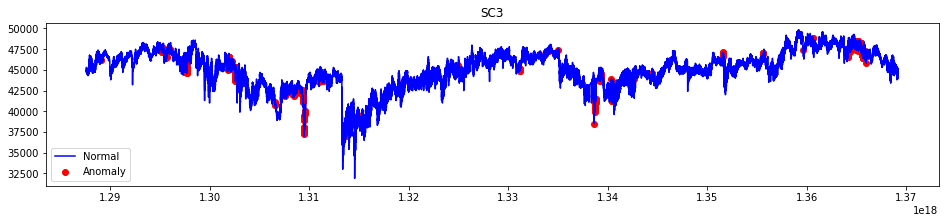

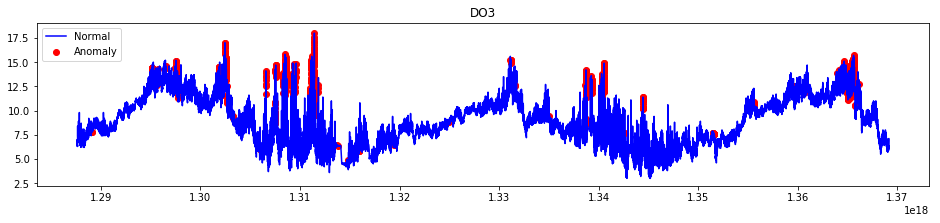

In [124]:
# #outliers by GD
# data = df[['CL3','SC3', 'DO3']]
# outliers_fraction = 0.01

for key in data.columns:
    plot_outlier(df, 'anomaly4', key)

In [126]:
df['anomaly1'].value_counts(),df['anomaly2'].value_counts(),df['anomaly3'].value_counts(),df['anomaly4'].value_counts()

(0    217791
 1      2199
 Name: anomaly1, dtype: int64, 0    217790
 1      2200
 Name: anomaly2, dtype: int64, 0    217789
 1      2201
 Name: anomaly3, dtype: int64, 0    217791
 1      2199
 Name: anomaly4, dtype: int64)

In [140]:
#All outliers

def All_Outliers(key):
    fig, ax = plt.subplots(figsize=(16,3))

    a = df.loc[df['anomaly1'] == 1, ['date_time_int', key]]
    b = df.loc[df['anomaly2'] == 1, ['date_time_int', key]]
    c = df.loc[df['anomaly3'] == 1, ['date_time_int', key]]
    d = df.loc[df['anomaly4'] == 1, ['date_time_int', key]]

    ax.plot(df['date_time_int'], df[key], color='k', alpha = 0.5, label = 'Normal')
    ax.scatter(b['date_time_int'],b[key], color='g', alpha = 0.5, label = 'Anomaly_Kmeans')
    ax.scatter(c['date_time_int'],c[key], color='r', alpha = 0.5, label = 'Anomaly_IF')
    ax.scatter(d['date_time_int'],d[key], color='b', alpha = 0.5, label = 'Anomaly_OCSVM')
    ax.scatter(a['date_time_int'],a[key], color='m', alpha = 0.5, label = 'Anomaly_Gaussian')

    plt.title(key)
    plt.legend(loc='upper left')
    plt.show()

In [139]:
# data.columns

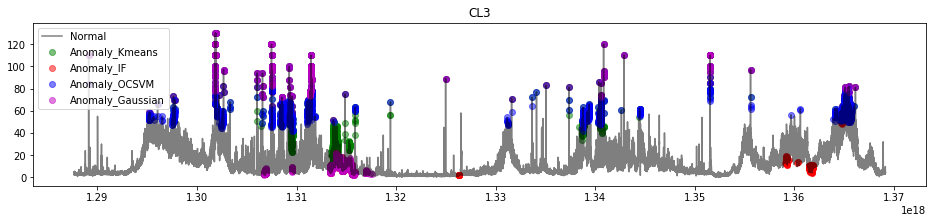

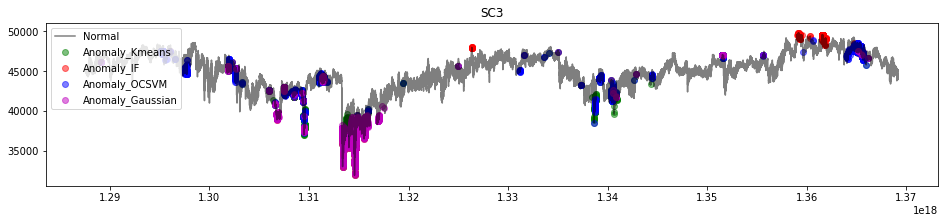

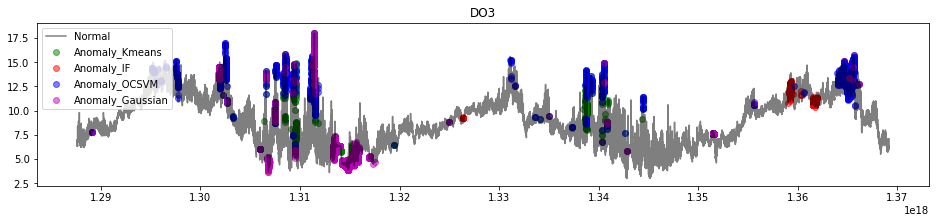

In [141]:
#outlier intersection 

# data = df[['CL3','SC3', 'DO3']]
# outliers_fraction = 0.01

for key in data.columns:
    All_Outliers(key)

In [164]:
test_anom = []
test_anom.append(np.array(np.where(df['anomaly1'] == 1)).flatten().tolist())
test_anom.append(np.array(np.where(df['anomaly2'] == 1)).flatten().tolist())
test_anom.append(np.array(np.where(df['anomaly3'] == 1)).flatten().tolist())
test_anom.append(np.array(np.where(df['anomaly4'] == 1)).flatten().tolist())

In [188]:
import itertools
merged = list(itertools.chain(*test_anom))

In [198]:
unique, counts = np.unique(merged, return_counts=True)

In [202]:
anomaly_index = []
for i in range(len(counts)):
    if counts[i] == 4 or counts[i] == 3:
        #print(unique[i])
        anomaly_index.append(unique[i])

In [206]:
df['all_anomaly'] = 0

In [207]:
for i in anomaly_index:
    df.at[i,'all_anomaly'] = 1

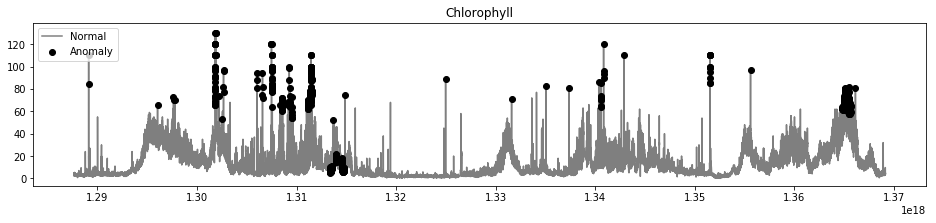

In [220]:
fig, ax = plt.subplots(figsize=(16,3))

a = df.loc[df['all_anomaly'] == 1, ['date_time_int', 'CL3']]

ax.plot(df['date_time_int'], df['CL3'], color='k', alpha = 0.5, label = 'Normal')
ax.scatter(a['date_time_int'],a['CL3'], color='k', label = 'Anomaly')#,marker='*')

plt.title('Chlorophyll')
plt.legend(loc='upper left')
plt.show()

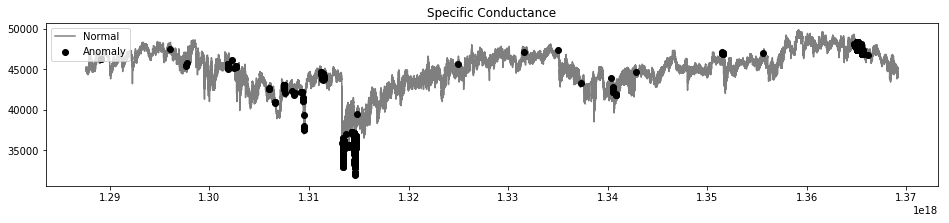

In [279]:
fig, ax = plt.subplots(figsize=(16,3))

a = df.loc[df['all_anomaly'] == 1, ['date_time_int', 'SC2']]

ax.plot(df['date_time_int'], df['SC2'], color='k', alpha = 0.5, label = 'Normal')
ax.scatter(a['date_time_int'],a['SC2'], color='k', label = 'Anomaly')#,marker='*')

plt.title('Specific Conductance')
plt.legend(loc='upper left')
plt.show()

/usr/local/lib/python3.5/dist-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


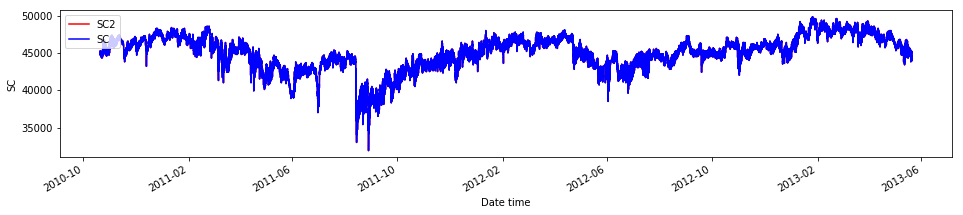

In [270]:
# temperary plan because i override the values 
rec_fill_nan(df, 'SC', 'SC2', 720, 1)
plot_gaps(df, 'SC', 'SC2')

/usr/local/lib/python3.5/dist-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


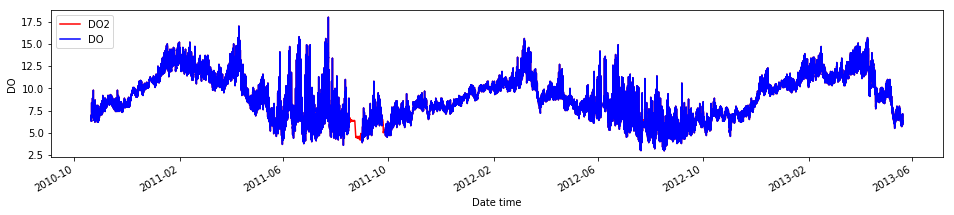

In [271]:
# temperary plan because i override the values 
rec_fill_nan(df, 'DO', 'DO2', 720, 1)
plot_gaps(df, 'DO', 'DO2')

/usr/local/lib/python3.5/dist-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


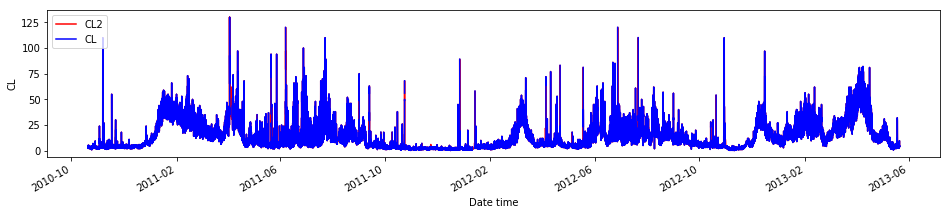

In [272]:
# temperary plan because i override the values 
rec_fill_nan(df, 'CL', 'CL2', 720, 1)
plot_gaps(df, 'CL', 'CL2')

In [264]:
# replace anomaly with nan
for key in data.columns:
    for anomaly in anomaly_index:
        df[key][anomaly] = np.nan

/usr/lib/python3/dist-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [282]:
# Gap in the original dataset
data1 = df[['CL3','DO3','SC3']]

for key in data1.columns:
    print(df[key].isna().sum())

1083
1083
1083


/usr/local/lib/python3.5/dist-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


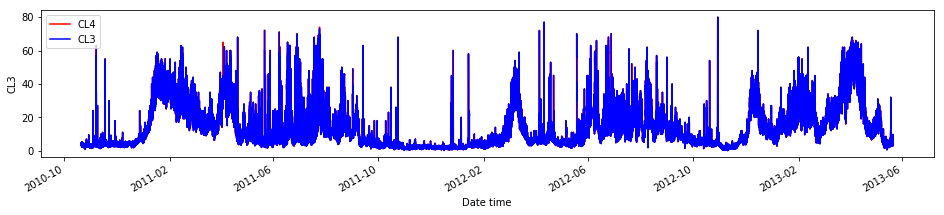

In [283]:
# fill Specific Chl recursively using 3 days data (current, before and after day)
rec_fill_nan(df, 'CL3', 'CL4', 720, 1)
plot_gaps(df, 'CL3', 'CL4')

/usr/local/lib/python3.5/dist-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


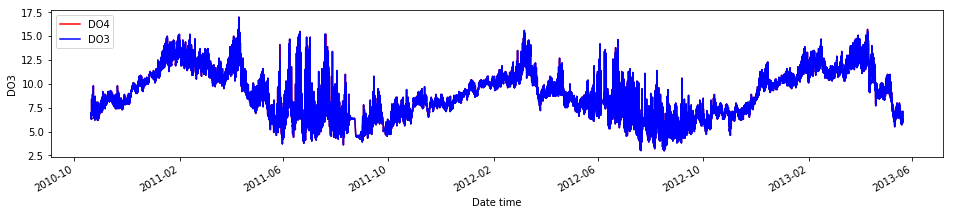

In [284]:
# fill Specific Chl recursively using 3 days data (current, before and after day)
rec_fill_nan(df, 'DO3', 'DO4', 720, 1)
plot_gaps(df, 'DO3', 'DO4')

/usr/local/lib/python3.5/dist-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


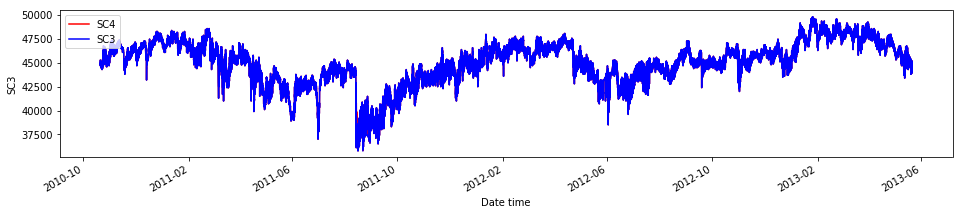

In [285]:
# fill Specific Chl recursively using 3 days data (current, before and after day)
rec_fill_nan(df, 'SC3', 'SC4', 720, 1)
plot_gaps(df, 'SC3', 'SC4')

# MLP with chopping

In [334]:
accuracy = [explained_variance_score,mean_absolute_error,mean_squared_error,r2_score]
#,mean_squared_log_error

In [306]:
warnings.filterwarnings('ignore')

Variables = ['DO','SC','CL']

def mlp(Variable,df,accuracy):
    #the following steps should be performed through all variables list
    for i in Variables:

        #group variables measurements by day (240 measurements)
        var = i
        mylist = df.groupby([df['datetime'].dt.date])
        xx = mylist[var].apply(list)
        date_measurements = [xx[i] for i in range(len(xx)) if len(xx[i])==240]
        date_measurements = np.array(date_measurements)

        #find the indices where there is no data and delete them
        inds = np.where(np.isnan(date_measurements))
        badind = list(set(inds[0]))
        date_measurements = np.delete(date_measurements, ([i for i in badind]), axis=0)

        #get the measurement of the variable every six hours
        inp = [date_measurements[i][j] for i in range(len(date_measurements)) for j in range(0,240,40)]
        inp = np.array(inp)

        #scale the variables
        print(var,'\n',stats.describe(inp)) 
        scaler = MinMaxScaler(feature_range=(0, 1))
        inp = scaler.fit_transform(inp.reshape(-1, 1))

        #reshape and split the data into training and testing sets (60% 20% resepctively)
        inp = inp.reshape(len(date_measurements),6)
        print(inp.shape)
        out = inp[1:][:]
        inp = inp[:-1][:]
        stop = int(len(inp)*0.6)
        x_train = inp[:stop][:]
        y_train = out[:stop][:]
        x_test = inp[stop:][:]
        y_test = out[stop:][:]

        #Multi-Layer Perceptron
        MLP = MLPRegressor(hidden_layer_sizes=(5,10),  activation='relu', solver='adam', random_state=1)
        MLP = MLP.fit(x_train, y_train)
        y_predict = MLP.predict(x_test)

        #inverse scale the data
        y_predict = scaler.inverse_transform(y_predict)
        y_test = scaler.inverse_transform(y_test)

        #calculate the accuracy of the model
        for acc in accuracy:
            acc_res = acc(y_test, y_predict)
            print(acc_res)

# Test variables with chopping nans

In [307]:
Variables = ['DO','SC','CL']
mlp(Variables,df,accuracy)

DO 
 DescribeResult(nobs=5148, minmax=(3.0, 15.3), mean=8.847533022533023, variance=5.550763293061233, skewness=0.1944540479013571, kurtosis=-0.7437080758249124)
(858, 6)
0.8807536778708213
0.5993709646398924
0.7247320466158119
0.879389128515364
SC 
 DescribeResult(nobs=5238, minmax=(32200.0, 49800.0), mean=45037.64795723559, variance=5085700.940010148, skewness=-0.9735033841166487, kurtosis=1.4650264021498955)
(873, 6)
0.597545025107955
931.6817491594438
1601937.894834479
0.44087701659031575
CL 
 DescribeResult(nobs=4404, minmax=(0.9, 90.0), mean=13.755313351498636, variance=150.10228609302177, skewness=1.435449811171513, kurtosis=2.1893982434359343)
(734, 6)
0.5021971213319798
5.784264077136005
78.42302493952552
0.47906447857443196


# mlp with filling gap with adj mean

In [308]:
Variables = ['DO2','SC2','CL2']
mlp(Variables,df,accuracy)

DO2 
 DescribeResult(nobs=5274, minmax=(3.0, 15.3), mean=8.783252569128221, variance=5.688422229959364, skewness=0.2080652924846252, kurtosis=-0.753213984027373)
(879, 6)
0.8875062096705836
0.5814199081336721
0.680501911100833
0.8862921535227666
SC2 
 DescribeResult(nobs=5274, minmax=(32200.0, 49800.0), mean=45036.23146932704, variance=5060321.56940354, skewness=-0.9716681952699485, kurtosis=1.4780038790364154)
(879, 6)
0.5841749457747257
956.6696241150031
1682949.8918401145
0.40965312772912577
CL2 
 DescribeResult(nobs=5274, minmax=(0.9, 90.0), mean=13.339108381623863, variance=148.17693760955635, skewness=1.5020558546845417, kurtosis=2.4072113274183122)
(879, 6)
0.5488399230163877
5.415671107508504
67.45527135681279
0.5315396141085212


# MLP after replacing anomalies with adjacent mean

In [309]:
Variables = ['DO3','SC3','CL3']
mlp(Variables,df,accuracy)

DO3 
 DescribeResult(nobs=4944, minmax=(3.4, 15.0), mean=8.742499763660488, variance=5.376770905099287, skewness=0.19240298296306516, kurtosis=-0.7397933905611516)
(824, 6)
0.8714426052409813
0.6040607742267463
0.7141645915200364
0.8694753902516418
SC3 
 DescribeResult(nobs=4944, minmax=(36800.0, 49800.0), mean=45124.7542008962, variance=4378353.71766332, skewness=-0.7720672991769749, kurtosis=0.7945333800350975)
(824, 6)
0.6354216631555465
827.1124602142787
1274245.3915998428
0.5397060349864422
CL3 
 DescribeResult(nobs=4944, minmax=(0.9, 59.86250000000018), mean=12.367874041660745, variance=118.62964310395164, skewness=1.2993677728393096, kurtosis=1.1741710807993169)
(824, 6)
0.5998655150042738
4.411697931640834
40.587738475970404
0.5916332369880214
